In [118]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [119]:
#df = pd.read_parquet("all_NLP_features.parquet")
#tones = pd.read_parquet("word_tone.parquet")

# list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
# read in all parquet files
df = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])

transcripts = df["transcript"]

In [120]:
# Get NLP and call info columns
df_nlp = df.loc[:, "num_transparency":"TONE1"]
df_other = df.loc[:, "ticker":"rating_date"]

df = pd.concat([df_other, df_nlp], axis=1)
df.head(5)

,ticker,fixed_quarter_date,earnings_call_date,Rating,rating_date,num_transparency,gf_score,word_count,num_questions,pos_score,...,Weak,Active,Passive,Ovrst,Undrst,PN,SW,AP,OU,TONE1
0,ROST,2015-10-01,2015-08-20,A,2014-09-15,0.09,10.126873,6173.0,36.0,0.124939,...,57.0,416.0,128.0,252.0,139.0,4.333333,9.052632,3.250000,1.812950,0.480239
1,ROST,2016-01-01,2015-11-19,A,2014-09-15,0.08,13.307526,8496.0,54.0,0.109466,...,62.0,511.0,185.0,386.0,201.0,3.468085,9.483871,2.762162,1.920398,0.210454
2,ROST,2016-07-01,2016-05-19,A,2014-09-15,0.06,11.906692,6747.0,36.0,0.224255,...,71.0,440.0,137.0,283.0,180.0,3.918033,5.633803,3.211679,1.572222,-0.695402
3,ROST,2016-10-01,2016-08-18,A,2014-09-15,0.11,10.482039,5200.0,38.0,0.145380,...,58.0,343.0,110.0,207.0,127.0,4.795455,6.293103,3.118182,1.629921,-0.140346
4,SAVE,2016-10-01,2016-07-29,A,2016-07-19,0.05,11.922028,8633.0,31.0,0.187902,...,119.0,626.0,217.0,385.0,255.0,2.788618,5.605042,2.884793,1.509804,-1.314347


In [121]:
# Get Finbert positivity score
# Combine finbert data
finbert_list = ['pos_result_0_500.txt',
                'pos_result_500_1000.txt',
                'pos_result_1000_1200.txt',
                 'pos_result_1200_1400.txt',
                 'pos_result_1400_1500.txt',
                 'pos_result_1500_2000.txt',
                 'pos_result_2000_2500.txt',
                 'pos_result_2500_3000.txt',
                 'pos_result_3000_3500.txt',
                 'pos_result_3500_4000.txt',
                 'pos_result_4000_4500.txt',
                 'pos_result_4500_5000.txt',
                 'pos_result_5000_5300.txt',
                 'pos_result_5300_5679.txt']

pos_score_fin = np.array([])

for filename in finbert_list:
    temp = np.loadtxt(filename)
    pos_score_fin = np.concatenate((pos_score_fin, temp))
    
print("Bad call index: ", np.where(pos_score_fin == -1))

# Replace pos_score of bad call with harvard pos_score 
pos_harvard = df["pos_score"].iloc[1154]
pos_score_fin[1154] = pos_harvard

df["pos_score_finbert"] = pos_score_fin

Bad call index:  (array([1154]),)


In [122]:
# Save to master df
df.to_parquet("All_Data_with_NLP_Finbert.parquet")

In [90]:
#df = df.drop(['transcript_tokens', 'transcript_words'], axis=1)
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

In [91]:
#df['tone'] = tones['TONE1']
#df = df.drop('readability', axis=1)
df["transcript"] = transcripts

## Outlier Checking

In [92]:
df = df.rename(columns={"TONE1": "tone"})


# Check tone outlier
idx = df['tone'].idxmax()

# Retrieve the row
max_row = df.loc[idx]
#print(df.loc[idx]['transcript'])

# Remove tone outlier
df = df.drop(labels=idx)

In [93]:
# Check num_questions=0
idx = df[df['num_questions']==0].index


texts = df.loc[idx, 'transcript']
#print(df.loc[6845, 'transcript'])    

# From manual inspection
idx_bad_transcripts = [2539, 1631, 3349]   

# Drop bad transcripts? - decided not to

In [94]:
#sample = df.loc[1845]['transcript']
#print(sample)
#sample.count("?")

## Boxplot of all features

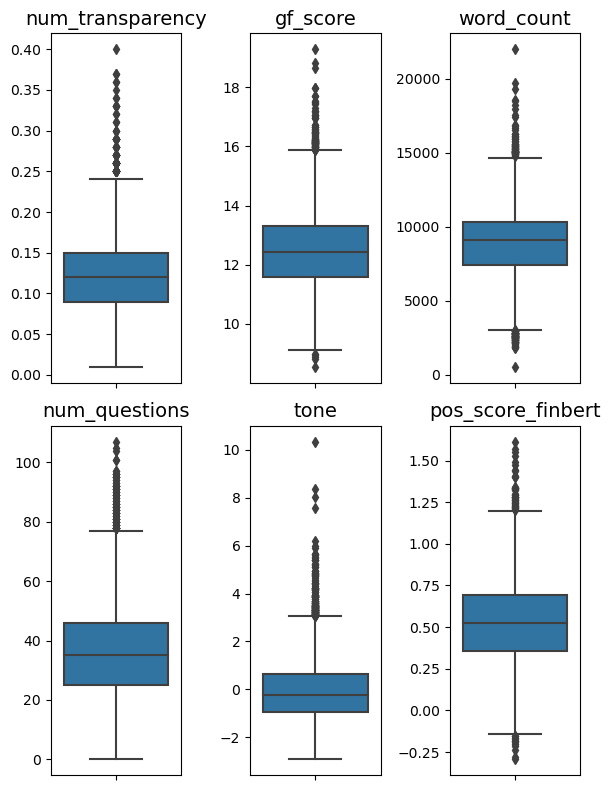

In [95]:
selected_columns = ['num_transparency', 'gf_score', 'word_count', 'num_questions', 'tone', 'pos_score_finbert']

df_box = df.loc[:, selected_columns]

fig, axes = plt.subplots(2, 3, figsize=(6, 8))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the grid for easy iteration

for i, col in enumerate(df_box.columns):
    sns.boxplot(y=df_box[col], ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_ylabel('')

# Hide any unused subplots if the number of plots is not a multiple of grid size
for ax in axes[len(df_box.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('NLP_Output_Final/all_NLP_histogram.png')

## Get num_question / call length

In [96]:
df['num_q_by_len'] = df['num_questions']/df['word_count']
df['len_by_q_count'] = df['word_count']/df['num_questions']
# inf values in len_by_q_count as q_count=0 for calls w/out Q&A sess
df.describe()

,num_transparency,gf_score,word_count,num_questions,pos_score,Positiv,Negativ,Strong,Weak,Active,...,Ovrst,Undrst,PN,SW,AP,OU,tone,pos_score_finbert,num_q_by_len,len_by_q_count
count,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,...,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000
mean,0.122295,12.506249,8828.844700,36.466078,0.186217,332.872438,106.219435,714.336219,97.322261,614.291166,...,379.824205,202.720141,3.427006,7.987027,2.980348,1.972952,-0.035288,0.533423,0.004130,inf
std,0.046399,1.315994,2479.428909,16.360083,0.100667,104.996830,41.465514,227.566162,37.283595,180.832640,...,116.517047,74.037941,1.272037,2.902145,0.544602,0.471569,1.279219,0.253375,0.001503,NaN
min,0.010000,8.551055,525.000000,0.000000,-0.204580,21.000000,7.000000,40.000000,6.000000,29.000000,...,27.000000,17.000000,1.100000,2.494505,1.592715,0.817778,-2.912621,-0.293205,0.000000,77.091954
25%,0.090000,11.584195,7392.750000,25.000000,0.116274,263.000000,76.000000,570.000000,71.000000,504.000000,...,309.000000,154.000000,2.522124,6.000000,2.598253,1.661146,-0.939668,0.356547,0.003075,198.918356
50%,0.120000,12.418846,9080.000000,35.000000,0.181354,334.000000,103.000000,707.500000,96.000000,623.000000,...,382.000000,203.000000,3.190309,7.418615,2.921930,1.909307,-0.221388,0.525426,0.003997,250.210425
75%,0.150000,13.305524,10329.000000,46.000000,0.252127,398.000000,132.000000,854.000000,120.000000,728.000000,...,448.000000,249.000000,4.066196,9.361742,3.297609,2.201111,0.661990,0.694182,0.005027,325.173387
max,0.400000,19.285766,22006.000000,107.000000,0.674876,994.000000,294.000000,2014.000000,297.000000,1584.000000,...,932.000000,565.000000,11.531915,35.093750,5.984615,5.925926,10.334498,1.612784,0.012972,inf


## Corr plot

/tmp/ipykernel_477678/1951582218.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.loc[:, 'num_transparency':'num_q_by_len'].corr()


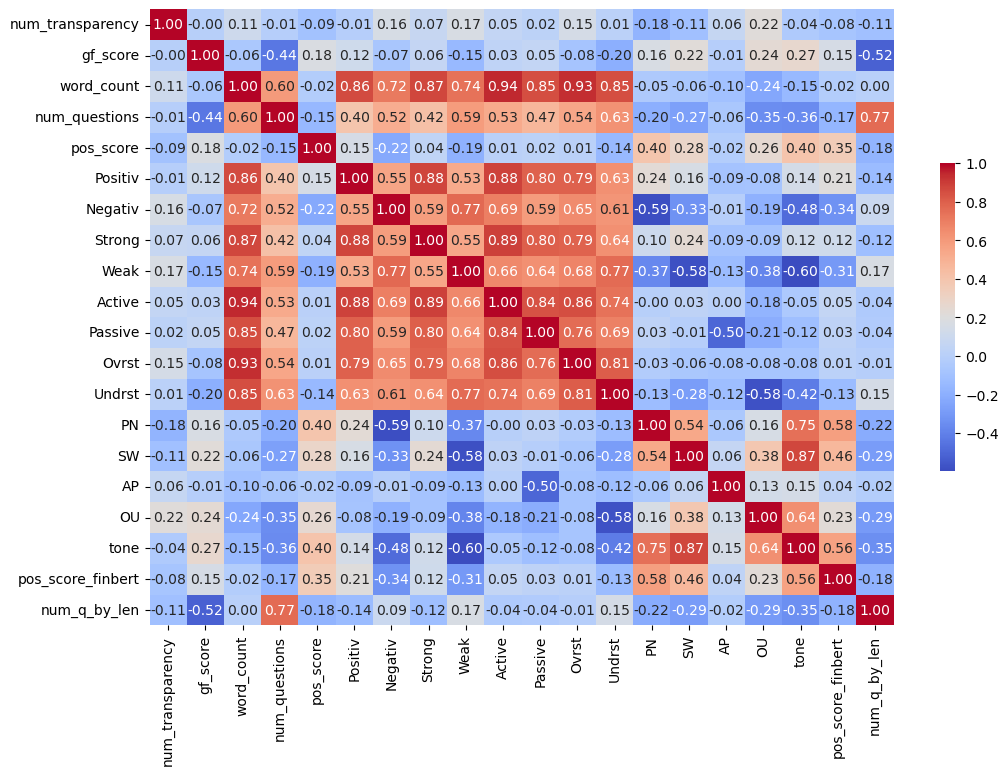

In [98]:
corr = df.loc[:, 'num_transparency':'num_q_by_len'].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})
plt.savefig('NLP_Output_Final/corr_plot_nlp.png')

## Histogram for all (NOT USED)

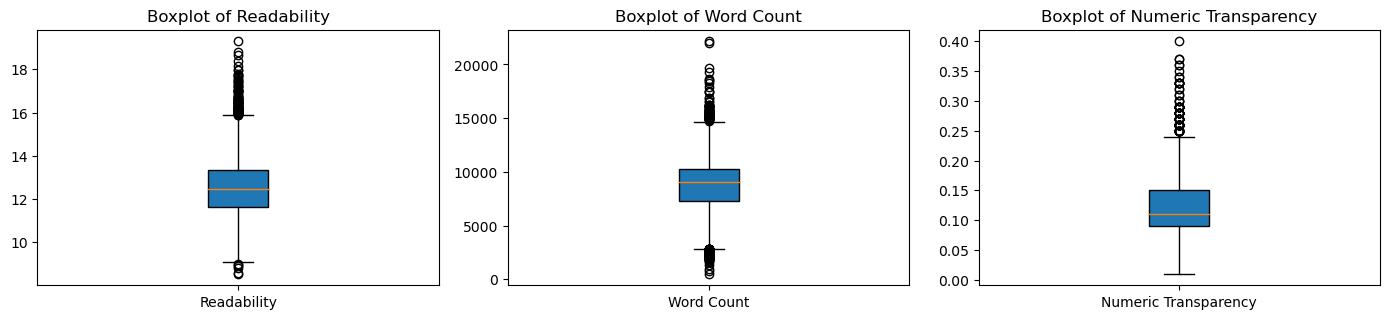

In [22]:
plt.figure(figsize=(14, 6))

# Boxplot for readability
plt.subplot(2, 3, 1)  # 1 row, 3 columns, first plot
plt.boxplot(df['readability'], patch_artist=True)
plt.title('Boxplot of Readability')
plt.xticks([1], ['Readability'])

# Boxplot for word_count
plt.subplot(2, 3, 2)  # 1 row, 3 columns, second plot
plt.boxplot(df['word_count'], patch_artist=True)
plt.title('Boxplot of Word Count')
plt.xticks([1], ['Word Count'])

plt.subplot(2, 3, 3)  # 1 row, 3 columns, third plot
plt.boxplot(df['num_transparency'], patch_artist=True)
plt.title('Boxplot of Numeric Transparency')
plt.xticks([1], ['Numeric Transparency'])

# Show the plot with tight layout
plt.tight_layout()
plt.show()

## Distribution of features by rating

     ticker Rating  num_transparency
0      AAPL    AAA               NaN
1      AAPL     AA          0.111111
2      AAPL      A               NaN
3      AAPL    BBB               NaN
4      AAPL     BB               NaN
...     ...    ...               ...
4365    ZTS      B               NaN
4366    ZTS    CCC               NaN
4367    ZTS     CC               NaN
4368    ZTS      C               NaN
4369    ZTS      D               NaN

[4370 rows x 3 columns]


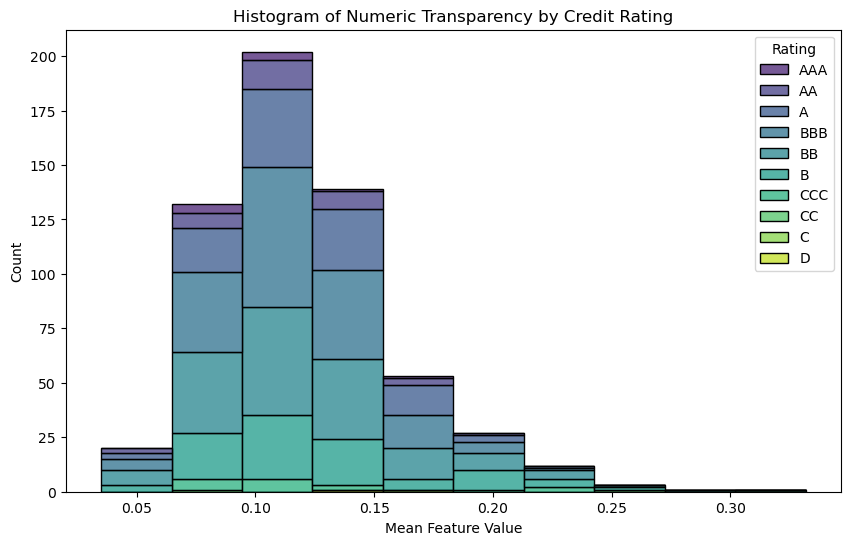

In [99]:
mean_feature_values = df.groupby(['ticker', 'Rating'])['num_transparency'].mean().reset_index()

# Display the means for verification
print(mean_feature_values)

# Step 2: Plot histograms of mean FeatureValue for each CreditRating
# This will create a histogram for each unique CreditRating in the dataset
plt.figure(figsize=(10, 6))
sns.histplot(data=mean_feature_values, x='num_transparency', hue='Rating', multiple='stack', bins=10, palette='viridis')
plt.title('Histogram of Numeric Transparency by Credit Rating')
plt.xlabel('Mean Feature Value')
plt.ylabel('Count')
plt.show()


In [26]:
df_sec_rating = df.groupby(['Sector', 'Rating'])['num_transparency'].mean().reset_index()

/tmp/ipykernel_1677713/661820212.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sector_data['RatingNum'], sector_data['num_transparency'],


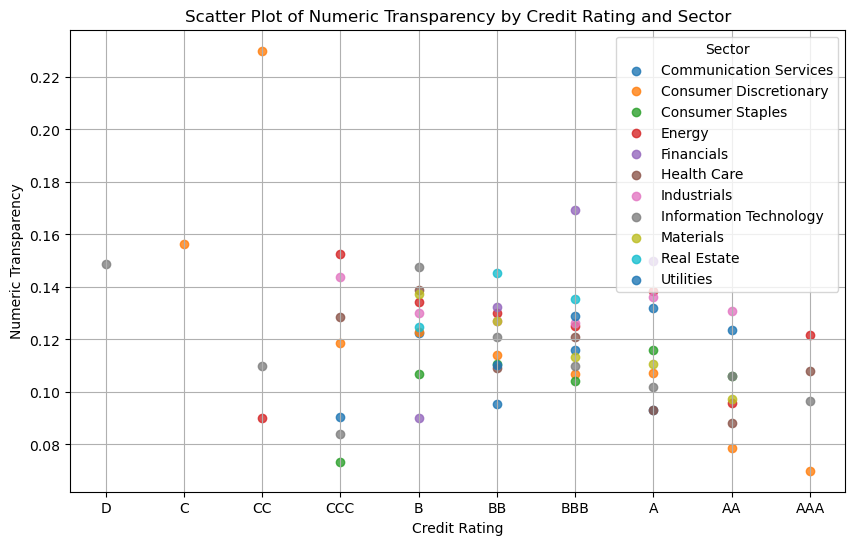

In [27]:
# Map the ratings to a numerical value for plotting
ratings_order = ['D', 'C', 'CC', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']
df_sec_rating['RatingNum'] = df_sec_rating['Rating'].apply(lambda x: ratings_order.index(x))

# Let's define a colormap that maps each sector to a color.
sectors = df_sec_rating['Sector'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(sectors)))
color_map = dict(zip(sectors, colors))

# Now let's plot the scatter plot.
plt.figure(figsize=(10, 6))
for sector in sectors:
    # Select only rows of the current sector
    sector_data = df_sec_rating[df_sec_rating['Sector'] == sector]
    plt.scatter(sector_data['RatingNum'], sector_data['num_transparency'], 
                label=sector, alpha=0.8, cmap='viridis')

# Formatting the plot
plt.xticks(range(len(ratings_order)), ratings_order)
plt.xlabel('Credit Rating')
plt.ylabel('Numeric Transparency')
plt.title('Scatter Plot of Numeric Transparency by Credit Rating and Sector')
plt.legend(title='Sector')
plt.grid(True)
plt.show()


## Examples of numeric transparency

In [28]:
#df.dropna(subset=['readability'])    # Drop 3 calls with wrong earning call

In [33]:
def find_nlp_feature_examples(feature_list, feat_name):
    # Finding the max value
    max_value = df[feat_name].max()
    # Finding the index of the max value
    max_index = df[feat_name].idxmax()
    
    min_value = df[feat_name].min()
    min_index = df[feat_name].idxmin()

    sample_good = df.loc[max_index]['transcript']
    sample_bad = df.loc[min_index]['transcript']
    #print(min_index)
    
    return sample_good, sample_bad

In [34]:
sample_good, sample_bad = find_nlp_feature_examples(df['num_transparency'], 'num_transparency')
#print(samples[0])

## Readability and Word Count

In [105]:
gf_word_by_cred = df.groupby('Rating')[['gf_score', "word_count"]].mean().reset_index()
gf_word_by_cred

,Rating,gf_score,word_count
0,AAA,12.855193,10980.356522
1,AA,12.144173,9537.101322
2,A,12.468259,9074.756506
3,BBB,12.534458,9244.339434
4,BB,12.524421,8403.372326
5,B,12.516793,7844.374359
6,CCC,12.332936,8715.757576
7,CC,12.373737,5474.666667
8,C,13.487426,9939.812500
9,D,13.021960,8799.333333


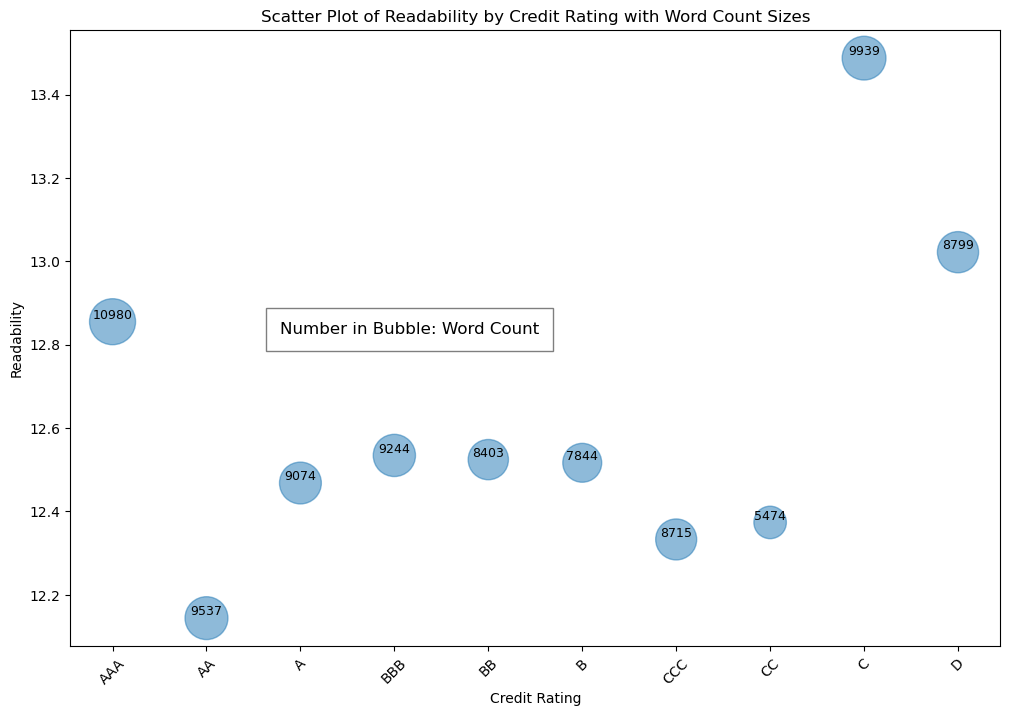

In [110]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter('Rating', 'gf_score', s=gf_word_by_cred['word_count']/10, alpha=0.5, data=gf_word_by_cred)

# Adding titles and labels
plt.xlabel('Credit Rating')
plt.ylabel('Readability')
plt.title('Scatter Plot of Readability by Credit Rating with Word Count Sizes')
plt.xticks(rotation=45)

for i, row in gf_word_by_cred.iterrows():
    plt.text(row['Rating'], row['gf_score'], f"{int(row['word_count'])}", fontsize=9,
             ha='center', va='bottom')
    
text = plt.text(0.3, 0.5, 'Number in Bubble: Word Count', fontsize=12, 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10},
                transform=plt.gcf().transFigure)

plt.savefig('NLP_Output_Final/bubble.png')
# Show plot with legend for sizes
#plt.legend(*scatter.legend_elements("sizes", num=6), title="Word Count / 10")

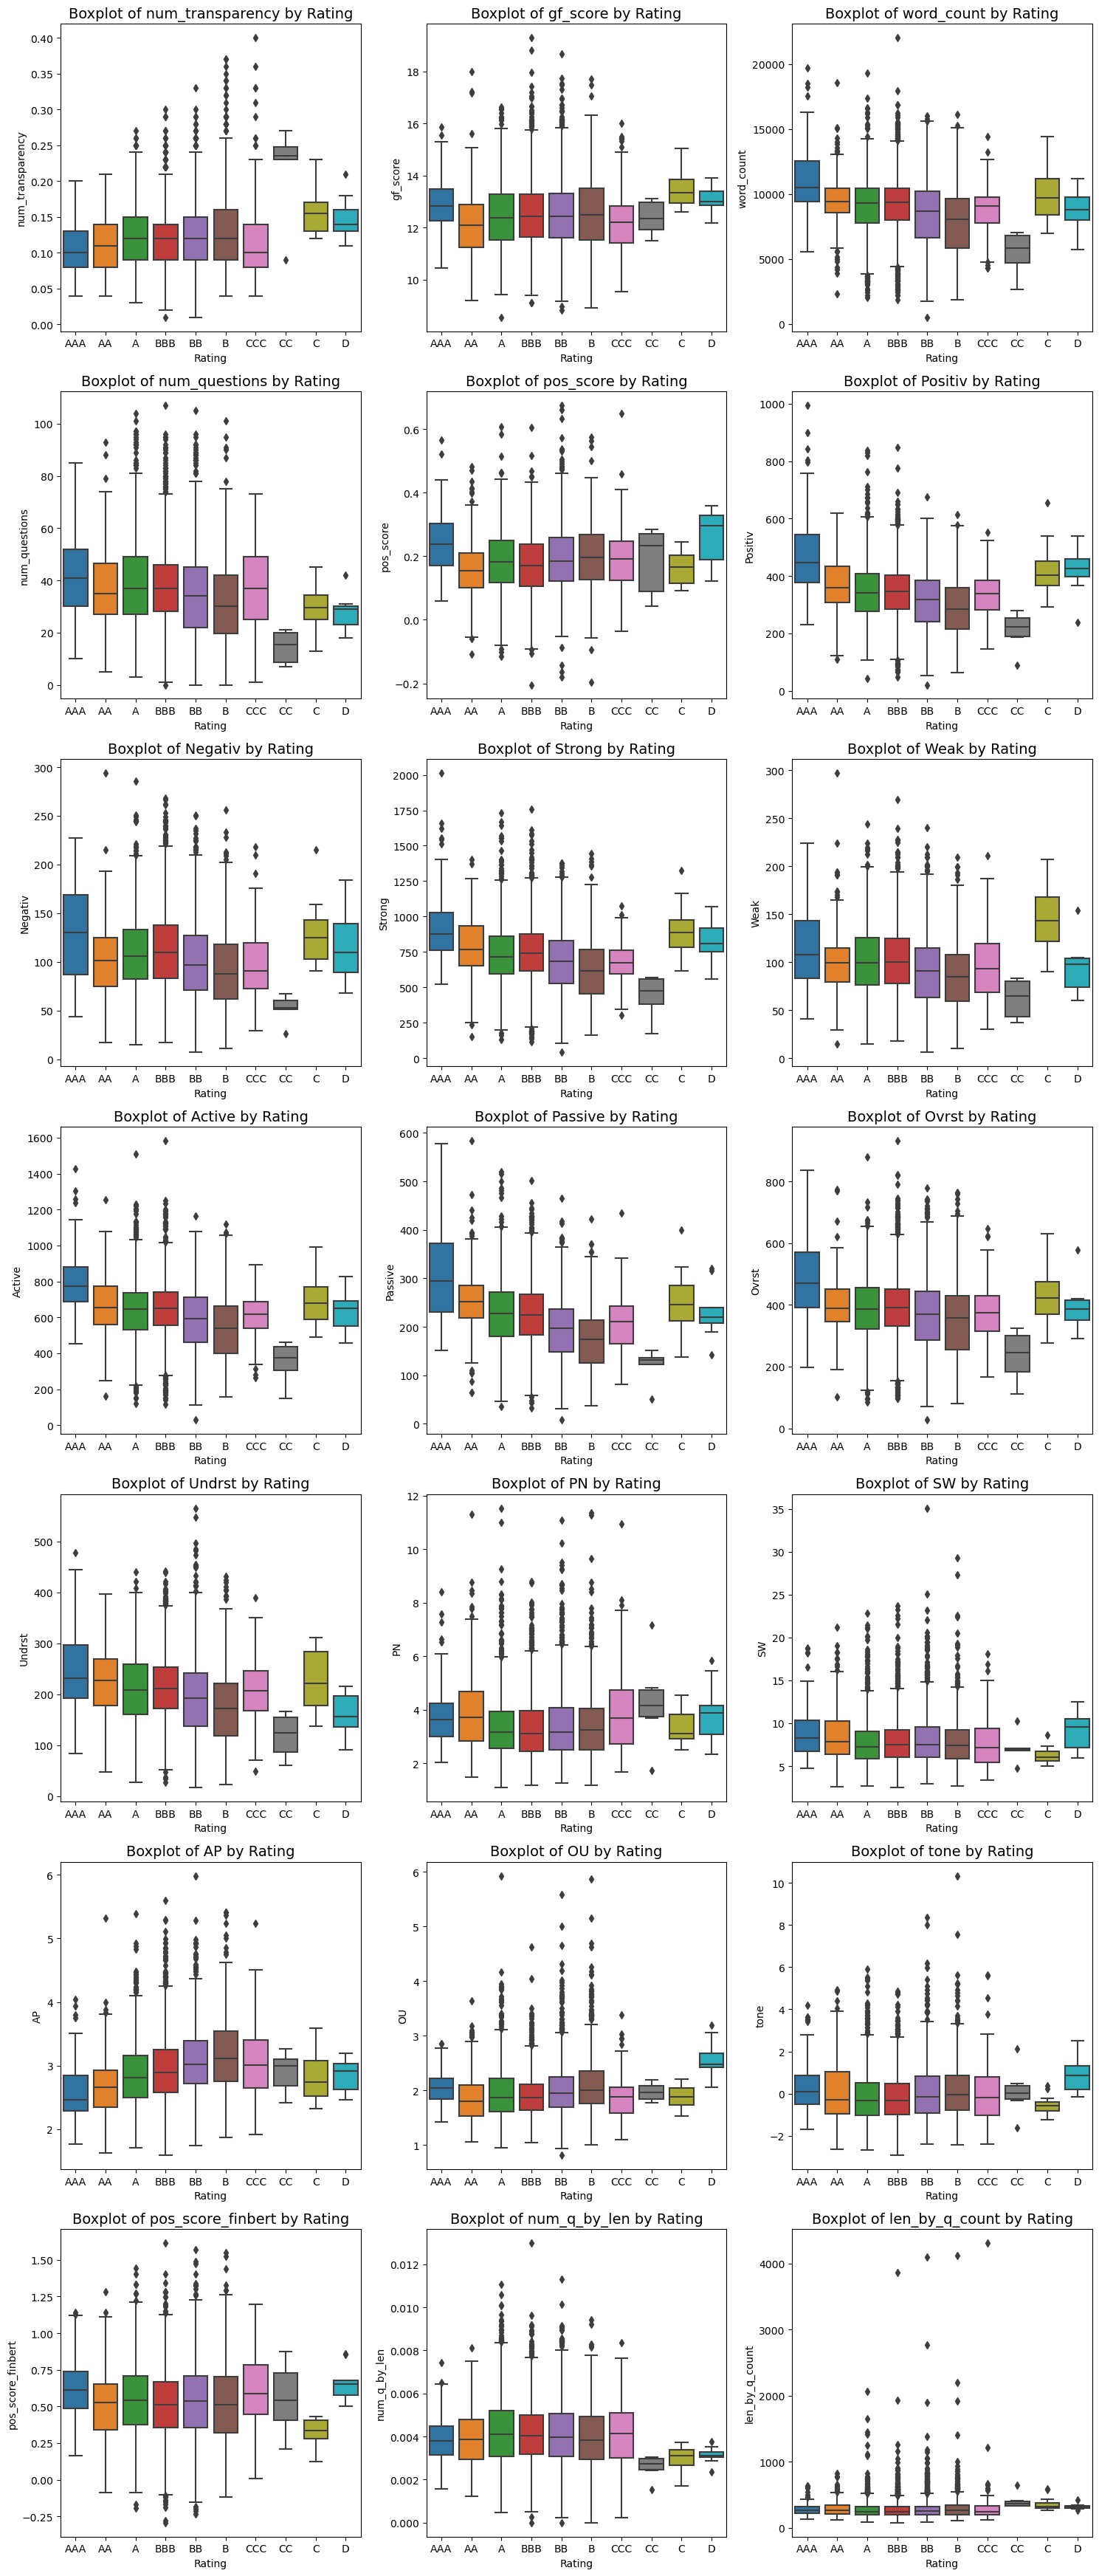

In [107]:
#df = df.drop('index', axis=1)
num_columns = df.select_dtypes(include=[float, int]).columns

# Determine the layout of the subplots (3 columns per row)
num_rows = int(len(num_columns) / 3) + (len(num_columns) % 3 > 0)

# Create subplots with the determined layout
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Iterate over the numerical columns to create a boxplot for each
for i, col in enumerate(num_columns):
    sns.boxplot(x='Rating', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Rating', fontsize=14)

# Hide any unused subplots if the number of plots is not a multiple of grid size
for ax in axes[len(num_columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [111]:
fig.savefig('NLP_Output_Final/hist_by_rating.png')